In [2]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/hitp/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')

import cpmd_io
import prepare_calculations as pc
import utils_qm as uqm
import numpy as np
import collections
import os

from scipy.integrate import simpson
from matplotlib import pyplot as plt
import scipy.interpolate as si

In [12]:
# def calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values):
#     """
#     prepare the run dirs for finite difference partial derivatives for small molecules
#     comp: name of compound
#     delta_lambda: delta for finite difference
#     lam: lambda_value for which derivatives will be calculated
#     """

#     partial_derivatives = []

#     for lam in lambda_values:
#         energies = []
#         for fd in ['bw', 'fw']:
#             logfile_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_{np.round(lam, 3)}/{atom}/{fd}/run.log'
#             with open(logfile_path, 'r') as f:
#                 logfile = f.readlines()
#             # get energy
#             if energy_contr == 'TOTAL ENERGY =':
#                 energies.append(cpmd_io.get_energy_contribution(logfile, energy_contr))
#             elif energy_contr == 'ELECTRONIC ENERGY':
                
#                 e_el_parts = []
#                 for e in ['TOTAL ENERGY =','(PSEUDO CHARGE I-I) ENERGY =', 'ESR =','ESELF =']:
#                     e_el_parts.append(cpmd_io.get_energy_contribution(logfile, e))
#                 e_nuc = e_el_parts[1]+e_el_parts[2]-e_el_parts[3]
#                 e_el = e_el_parts[0]-e_nuc
#                 energies.append(e_el)
#         partial_derivatives.append((energies[1]-energies[0])/(2*delta_lambda))
#     return(partial_derivatives)


def get_energy_contribution_wrapper(logfile_path, energy_contr):
    """
    prepare the run dirs for finite difference partial derivatives for small molecules
    comp: name of compound
    delta_lambda: delta for finite difference
    lam: lambda_value for which derivatives will be calculated
    """
    energy = None
    with open(logfile_path, 'r') as f:
        logfile = f.readlines()
            # get energy
    if energy_contr == 'total':
        energy = cpmd_io.get_energy_contribution(logfile, 'TOTAL ENERGY =')
    elif energy_contr == 'ion_pseudo':
        energy = cpmd_io.get_energy_contribution(logfile, '(PSEUDO CHARGE I-I) ENERGY =')
    elif energy_contr == 'ion_self':
        energy = cpmd_io.get_energy_contribution(logfile, 'ESELF =')
    elif energy_contr == 'ion_esr':
        energy = cpmd_io.get_energy_contribution(logfile, 'ESR =')
    elif energy_contr == 'kinetic':
        energy = cpmd_io.get_energy_contribution(logfile, 'KINETIC ENERGY =')
    elif energy_contr == 'xc_corr':
        energy = cpmd_io.get_energy_contribution(logfile, 'EXCHANGE-CORRELATION ENERGY =') 
    elif energy_contr == 'local_pp':
        energy = cpmd_io.get_energy_contribution(logfile, 'LOCAL PSEUDOPOTENTIAL ENERGY')
    elif energy_contr == 'nonlocal_pp':
        energy = cpmd_io.get_energy_contribution(logfile, 'N-L PSEUDOPOTENTIAL ENERGY =')
    elif energy_contr == 'electrostatic':
        energy = cpmd_io.get_energy_contribution(logfile, 'ELECTROSTATIC ENERGY =')
    elif energy_contr == 'electronic':
        e_el_parts = []
        for e in ['TOTAL ENERGY =','(PSEUDO CHARGE I-I) ENERGY =', 'ESR =','ESELF =']:
            e_el_parts.append(cpmd_io.get_energy_contribution(logfile, e))
        e_nuc = e_el_parts[1]+e_el_parts[2]-e_el_parts[3]
        e_el = e_el_parts[0]-e_nuc
        energy = e_el
    elif energy_contr == 'potential':
        e_pot_parts = []
        for e in ['TOTAL ENERGY =','(PSEUDO CHARGE I-I) ENERGY =', 'ESR =','ESELF =','KINETIC ENERGY =']:
            e_pot_parts.append(cpmd_io.get_energy_contribution(logfile, e))
        epot = e_pot_parts[0] - (e_pot_parts[1]+e_pot_parts[2]-e_pot_parts[3]) - e_pot_parts[4]
        energy = epot
    elif energy_contr == 'nuclear':
        e_nuc_parts = []
        for e in ['(PSEUDO CHARGE I-I) ENERGY =', 'ESR =','ESELF =']:
            e_nuc_parts.append(cpmd_io.get_energy_contribution(logfile, e))
        e_nuc = e_nuc_parts[0]+e_nuc_parts[1]-e_nuc_parts[2]
        energy = e_nuc
    assert energy != None, f'Could not extract {energy_contr} from {logfile_path}'
    return(energy)

def calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values):
    """
    prepare the run dirs for finite difference partial derivatives for small molecules
    comp: name of compound
    delta_lambda: delta for finite difference
    lam: lambda_value for which derivatives will be calculated
    """

    partial_derivatives = []

    for lam in lambda_values:
        energies = []
        for fd in ['bw', 'fw']:
            logfile_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_{np.round(lam, 3)}/{atom}/{fd}/run.log'
            with open(logfile_path, 'r') as f:
                logfile = f.readlines()
            # get energy
            energies.append(get_energy_contribution_wrapper(logfile_path, energy_contr))
        partial_derivatives.append((energies[1]-energies[0])/(2*delta_lambda))
    return(partial_derivatives)

# derivatives

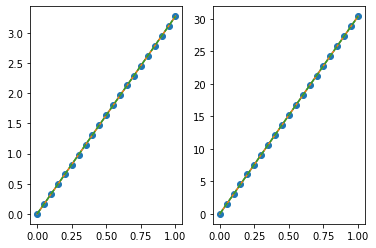

In [52]:
comp = 'HF'
delta_lambda = 5e-5

# read optimized geometry and extract molecule specific parameters
xyz_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/GEOMETRY.xyz'
atom_symbols, nuc_charges, positions, valence_charges = pc.parse_xyz_for_CPMD_input(xyz_path)

energy_contr = 'ion_pseudo'
e_tot_trapz = 0
e_tot_splines = 0
e_tot_simps = 0
e_fit = 0
fig, ax = plt.subplots(1,2)

for atom in atom_symbols['elIdx']:
    lambda_values = np.arange(0.05, 1.05, 0.05)
    partial_derivatives = [0.0]
    partial_derivatives.extend(calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values))

    lambda_values = np.arange(0.0, 1.05, 0.05)
    e_tot_trapz += np.trapz(partial_derivatives, lambda_values)
    e_tot_simps += simpson(partial_derivatives, lambda_values)
    spline = si.CubicSpline(lambda_values, partial_derivatives)
    spline_lam = np.linspace(0,1, 50)
    spline_fit = spline(np.linspace(0,1, 50))
    e_tot_splines += spline.integrate(0,1)
    
    nuc_fit = partial_derivatives[-1]*spline_lam
    
    e_fit += partial_derivatives[-1]/2
    
    if 'H' in atom:
        ax[0].plot(lambda_values, partial_derivatives, '-o')
        ax[0].plot(spline_lam, spline_fit)
        ax[0].plot(spline_lam, nuc_fit, '--')
        #ax[0].set_xlim([0,0.5])
    else:
        ax[1].plot(lambda_values, partial_derivatives, '-o')
        ax[1].plot(spline_lam, spline_fit)
        ax[1].plot(spline_lam, nuc_fit, '--')

In [ ]:
logfile_path1 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_1.0/run.log'
with open(logfile_path1, 'r') as f:
    logfile1 = f.readlines()

logfile_path0 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_0.0/run.log'
with open(logfile_path0, 'r') as f:
    logfile0 = f.readlines()
energy_contr = 'TOTAL ENERGY ='
e_tot_ref = cpmd_io.get_energy_contribution(logfile1, energy_contr)-cpmd_io.get_energy_contribution(logfile0, energy_contr)

In [ ]:
print(e_tot_splines-e_tot_ref)
print(e_tot_trapz-e_tot_ref)
print(e_tot_simps-e_tot_ref)

In [ ]:
# comp = 'HCN'
delta_lambda = 5e-5
energy_contr = 'electronic'
e_el_trapz = 0
e_el_simps = 0
e_el_splines = 0

plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,2)

for atom in atom_symbols['elIdx']:
    lambda_values = np.arange(0.05, 1.05, 0.05)
    partial_derivatives = [0.0]
    partial_derivatives.extend(calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values))

    lambda_values = np.arange(0.0, 1.05, 0.05)
    e_el_trapz += np.trapz(partial_derivatives, lambda_values)
    e_el_simps += simpson(partial_derivatives, lambda_values)
    spline = si.CubicSpline(lambda_values, partial_derivatives)
    e_el_splines += spline.integrate(0,1)
    
    if 'H' in atom:
        ax[0].plot(lambda_values, partial_derivatives, '-o')
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$\frac{\partial E}{\partial V_I^{PP}}$')
        ax[0].set_title('Hydrogen')
    else:
        ax[1].plot(lambda_values, partial_derivatives, '-o', label = atom)
        ax[1].set_xlabel(r'$\lambda$')
        ax[1].set_title('No Hydrogen')
        ax[1].legend(frameon = False)

In [ ]:
logfile_path1 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_1.0/run.log'
with open(logfile_path1, 'r') as f:
    logfile1 = f.readlines()

logfile_path0 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_0.0/run.log'
with open(logfile_path0, 'r') as f:
    logfile0 = f.readlines()

def get_e_el(logfile):
    e_el_parts = []
    for e in ['TOTAL ENERGY =','(PSEUDO CHARGE I-I) ENERGY =', 'ESR =','ESELF =']:
        e_el_parts.append(cpmd_io.get_energy_contribution(logfile, e))
    e_nuc = e_el_parts[1]+e_el_parts[2]-e_el_parts[3]
    e_el = e_el_parts[0]-e_nuc
    return(e_el)
    
e_el_ref = get_e_el(logfile1)-get_e_el(logfile0)

In [ ]:
print(f'Trapezoidal = {e_el_trapz-e_el_ref}')
print(f'Simpson = {e_el_simps-e_el_ref}')
print(f'Cubic splines = {e_el_splines-e_el_ref}')


### Compare atomic energies

In [71]:
def calculate_atomic_energies(atom_symbols, comp, delta_lambda, energy_contr, method):
    atomic_energies = dict()
    for atom in atom_symbols['elIdx']:
        lambda_values = np.arange(0.05, 1.05, 0.05)
        partial_derivatives = [0.0]
        partial_derivatives.extend(calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values))
        lambda_values = np.arange(0.0, 1.05, 0.05)

        if method == 'trapz':
            atomic_energies[atom] = np.trapz(partial_derivatives, lambda_values)
        elif method == 'simpson':
            atomic_energies[atom] = simpson(partial_derivatives, lambda_values)
        elif method == 'cubic_splines':
            spline = si.CubicSpline(lambda_values, partial_derivatives)
            atomic_energies[atom] = spline.integrate(0,1)

    return(atomic_energies)

def calculate_atomic_nuclear_repulsion(atom_symbols, comp, delta_lambda, method):
    atomic_energies = dict()
    for atom in atom_symbols['elIdx']:
        nuclear_parts = 0
        for energy_contr in ['ion_pseudo', 'ion_esr', 'ion_self']:
            lambda_values = np.arange(0.05, 1.05, 0.05)
            partial_derivatives = [0.0]
            partial_derivatives.extend(calculate_partial_derivatives(atom, comp, delta_lambda, energy_contr, lambda_values))
            lambda_values = np.arange(0.0, 1.05, 0.05)

            if energy_contr == 'ion_pseudo':
                if method == 'trapz':
                    nuclear_parts += np.trapz(partial_derivatives, lambda_values)
                elif method == 'simpson':
                    nuclear_parts += simpson(partial_derivatives, lambda_values)
                elif method == 'cubic_splines':
                    spline = si.CubicSpline(lambda_values, partial_derivatives)
                    nuclear_parts += spline.integrate(0,1)
            elif energy_contr == 'ion_esr':
                nuclear_parts += partial_derivatives[-1]/2
            elif energy_contr == 'ion_self':
                nuclear_parts -= partial_derivatives[-1]/2
        atomic_energies[atom] = nuclear_parts
    return(atomic_energies)

def calculate_atomic_energies_tot(atom_symbols, comp, delta_lambda, energy_contr, method):
    e_el = calculate_atomic_energies(atom_symbols, comp, delta_lambda, energy_contr, method)
    e_nuc = calculate_atomic_nuclear_repulsion(atom_symbols, comp, delta_lambda, method)
    e_tot = dict()
    for k in e_el.keys():
        e_tot[k] = e_el[k] + e_nuc[k]
    return(e_tot)


In [87]:
compounds = ['CH4', 'H2O','NH3', 'HF', 'ethane', 'ethene', 'ethyne', 'HCN']
delta_lambda = 5e-5
method = 'simpson'
atomic_energies = {'electronic':[], 'nuclear':[],'total':[]}
for comp in compounds:
    # read optimized geometry and extract molecule specific parameters
    xyz_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/GEOMETRY.xyz'
    atom_symbols, nuc_charges, positions, valence_charges = pc.parse_xyz_for_CPMD_input(xyz_path)
    
    # electronic part
    energy_contr = 'electronic'
    atomic_energies_el = calculate_atomic_energies(atom_symbols, comp, delta_lambda, energy_contr, method)
    atomic_energies['electronic'].append(atomic_energies_el)
    # nuclear repulsion
    atomic_energies_nuc = calculate_atomic_nuclear_repulsion(atom_symbols, comp, delta_lambda, method)
    atomic_energies['nuclear'].append(atomic_energies_nuc)
    # total energy
    atomic_energies_tot = calculate_atomic_energies_tot(atom_symbols, comp, delta_lambda, energy_contr, method)
    atomic_energies['total'].append(atomic_energies_tot)

In [103]:
atomic_energies_element = {'H':[], 'C':[], 'N':[], 'O':[], 'F':[]}
for comp_dict in atomic_energies['total']:
    for k in comp_dict:
        for k_el in atomic_energies_element:
            if k_el in k:
                atomic_energies_element[k_el].append(comp_dict[k])

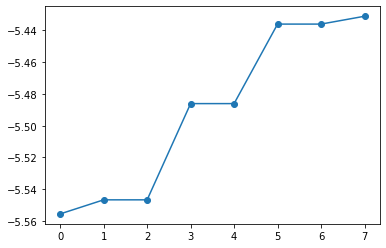

In [111]:
plt.plot(atomic_energies_element['C'], '-o')

In [96]:
[-5.555546666671601,
 -5.546680000001977,
 -5.486093333333395,
 -5.4360299999981905,
 -5.431088333327265]

[-5.555546666671601,
 -5.546680000001977,
 -5.546680000001977,
 -5.486093333333395,
 -5.486093333333395,
 -5.4360299999981905,
 -5.4360299999981905,
 -5.431088333327265]

### Mean error of different integration methods

In [78]:
def calculate_error(atomic_dict, energy_contr, comp):
    logfile_path1 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_1.0/run.log'
    logfile_path0 = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/lam_0.0/run.log'
    ref = get_energy_contribution_wrapper(logfile_path1, energy_contr)-get_energy_contribution_wrapper(logfile_path0, energy_contr)
    e_sum = 0
    for k in atomic_dict.keys():
        e_sum += atomic_dict[k] 
        
    return(np.abs(e_sum - ref))

In [86]:
for method in ['trapz', 'simpson', 'cubic_splines']:
    compounds = ['CH4', 'H2O','NH3', 'HF', 'ethane', 'ethene', 'ethyne', 'HCN']
    delta_lambda = 5e-5
    errors = {'electronic':[], 'nuclear':[],'total':[]}
    for comp in compounds:
        # read optimized geometry and extract molecule specific parameters
        xyz_path = f'/data/sahre/projects/finite_differences/small_molecules/{comp}/GEOMETRY.xyz'
        atom_symbols, nuc_charges, positions, valence_charges = pc.parse_xyz_for_CPMD_input(xyz_path)

        # electronic part
        energy_contr = 'electronic'
        atomic_energies_el = calculate_atomic_energies(atom_symbols, comp, delta_lambda, energy_contr, method)
        err_el = calculate_error(atomic_energies_el, 'electronic', comp)
        errors['electronic'].append(err_el)
        # nuclear repulsion
        atomic_energies_nuc = calculate_atomic_nuclear_repulsion(atom_symbols, comp, delta_lambda, method)
        err_nuc = calculate_error(atomic_energies_nuc, 'nuclear', comp)
        errors['nuclear'].append(err_nuc)
        # total energy
        atomic_energies_tot = calculate_atomic_energies_tot(atom_symbols, comp, delta_lambda, energy_contr, method)
        err_tot = calculate_error(atomic_energies_tot, 'total', comp)
        errors['total'].append(err_tot)
    
    print('##################################')
    print(f'Integration method: {method}')
    for k in errors:
        print(f'{k} {np.array(errors[k]).mean()}')

##################################
Integration method: trapz
electronic 0.014255411247598104
nuclear 0.0003308150008683175
total 0.014135318743985548
##################################
Integration method: simpson
electronic 0.01115608458445072
nuclear 0.00019935666809267616
total 0.011174158750085872
##################################
Integration method: cubic_splines
electronic 0.01178819438344969
nuclear 0.00020598204508046059
total 0.01171152695856248


# UEG

In [ ]:
ves = ['ve_8', 've_10', 've_12', 've_14']
boxsizes = [15, 20, 22.5, 25]
energy_ve = dict()
for ve in ves:
    energy_ve[ve] = []
    for boxsize in boxsizes:
        path_log = f'/data/sahre/projects/finite_differences/small_molecules/UEG/{ve}/a_{boxsize}/run.log'
        with open(path_log, 'r') as f:
            logfile = f.readlines()
        conv_thresh = 1e-6
        # status = check_convergence(logfile, conv_thresh)
        status = 'converged'
        if status == 'not converged':
            print(path_log)
        energy_ve[ve].append(cpmd_io.get_energy_contribution(logfile, 'TOTAL ENERGY ='))

In [ ]:
plt.rcParams['font.size'] = 15
for k in energy_ve.keys():
    plt.plot(boxsizes, np.array(energy_ve[k])/float(k.split('_')[1]), '-o',label = k)
plt.legend(bbox_to_anchor = (1.05,1))
plt.xlabel(r'a (Ang)')
plt.ylabel(r'E UEG (Ha)')

In [ ]:
plt.rcParams['font.size'] = 15
for k in energy_ve.keys():
    plt.plot(float(k.split('_')[1])/np.array(boxsizes)**3, np.array(energy_ve[k])/float(k.split('_')[1]), '-o',label = k)
plt.legend(bbox_to_anchor = (1.05,1))
plt.xlabel(r'$\rho$ (1/Ang^3)')
plt.ylabel(r'E UEG (Ha/e)')

In [ ]:
boxsizes